# Notebook comparing Chris' Mock with previous results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table , Column
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
import copy
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'stixgeneral'
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
cat_file = '/users/astro/desktop/github/satellite_fraction/data/mock.npy'

mock = Table(np.load(cat_file))
mock

id,pid,upid,Mpeak,Vmax@Mpeak,halo_x,halo_y,halo_z,vx,vy,vz,stellar_mass
int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64
1833071546,-1,-1,237951896119226.8,924.44,4.03144,17.23413,91.36662,-200.18,-261.51,267.78,480056572597.5108
1833071631,1833071546,1833071546,10133835030249.373,383.09,3.78748,16.94847,91.23265,-603.12,-1170.77,-348.34,80841498549.00124
1833035113,-1,-1,117509222369780.14,757.59,13.06563,62.39772,13.3931,-121.53,29.71,66.51,233307841356.99008
1833035144,1833035096,1833035099,1601593625498.008,197.84,13.81267,62.12096,14.04833,-374.55,-347.37,-226.92,55246740849.27218
1833035169,1833035094,1833035113,4678176184152.28,247.73,13.49765,62.22673,13.88134,-336.37,36.37,-731.41,153534073976.68866
1833035170,1833035099,1833035099,3696325807879.593,273.31,13.96447,62.16499,14.47905,-122.37,210.76,-566.07,147563406270.24774
1833622686,-1,-1,37957798435886.086,492.94,50.06574,84.10212,74.073,-297.98,295.95,-91.92,207350394613.7922
1833622688,1833622686,1833622686,2696768481629.0396,248.15,50.00916,83.92558,74.03111,-331.83,609.27,-58.91,183425904832.6724
1833622695,1833622686,1833622686,5417884019477.6455,315.48,50.07149,84.13984,74.08667,-625.21,530.13,-301.42,110366540870.48431


In [3]:
#change masses to log scale
mock['stellar_mass'] = np.log10(mock['stellar_mass'])
mock

id,pid,upid,Mpeak,Vmax@Mpeak,halo_x,halo_y,halo_z,vx,vy,vz,stellar_mass
int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64
1833071546,-1,-1,237951896119226.8,924.44,4.03144,17.23413,91.36662,-200.18,-261.51,267.78,11.681292420123887
1833071631,1833071546,1833071546,10133835030249.373,383.09,3.78748,16.94847,91.23265,-603.12,-1170.77,-348.34,10.907634355381738
1833035113,-1,-1,117509222369780.14,757.59,13.06563,62.39772,13.3931,-121.53,29.71,66.51,11.367929335454031
1833035144,1833035096,1833035099,1601593625498.008,197.84,13.81267,62.12096,14.04833,-374.55,-347.37,-226.92,10.742306662937674
1833035169,1833035094,1833035113,4678176184152.28,247.73,13.49765,62.22673,13.88134,-336.37,36.37,-731.41,11.18620477393599
1833035170,1833035099,1833035099,3696325807879.593,273.31,13.96447,62.16499,14.47905,-122.37,210.76,-566.07,11.168978671678772
1833622686,-1,-1,37957798435886.086,492.94,50.06574,84.10212,74.073,-297.98,295.95,-91.92,11.31670486621766
1833622688,1833622686,1833622686,2696768481629.0396,248.15,50.00916,83.92558,74.03111,-331.83,609.27,-58.91,11.263460670109453
1833622695,1833622686,1833622686,5417884019477.6455,315.48,50.07149,84.13984,74.08667,-625.21,530.13,-301.42,11.042837431022267


In [4]:
#make a mass cut
mock_use = mock[mock['stellar_mass']>11.5]
len(mock_use)

193793

In [5]:
# apply rsd
from halotools.mock_observables import apply_zspace_distortion
from astropy.cosmology import Planck15 as cosmo
z_dis = apply_zspace_distortion(mock_use['halo_z'], mock_use['vz'], .37, cosmo, 1000.0)
mock_use['z_dist'] = z_dis

/Users/astro/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
# first define the cosmology in colossus
# I'm using the same cosmology stated in SMDPL documentation
import colossus
from colossus.cosmology import cosmology
params = {'flat': True , 'H0': 67.77 , 'Om0': 0.307115 , 'Ob0': 0.048206, 'sigma8': 0.8228, 'ns': 0.96}
h = 0.6777
cosmology.addCosmology('SMDPL',params) # this is what Song had me use when doing the sat frac
cosmo = cosmology.setCosmology('SMDPL')
from colossus.halo import mass_so
# get rid of h in spatial coords
mock_use['z_dist'] = mock_use['z_dist']/h
mock_use['x'] = mock_use['halo_x']/h
mock_use['y'] = mock_use['halo_y']/h

In [13]:
centrals = mock_use[mock_use['upid'] == -1]
sats = mock_use[mock_use['upid'] != -1]

print(len(centrals), len(sats))

# from Song's satellite finding code
mass_bins = [11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3]

hist_all, edges_all = np.histogram(mock_use['stellar_mass'], mass_bins)
hist_cen, edges_cen = np.histogram(centrals['stellar_mass'], mass_bins)
hist_sat, edges_sat = np.histogram(sats['stellar_mass'], mass_bins)

mass_center_cb = np.log10((10**edges_all[1:] + 10**edges_all[:-1]) / 2)

f_sat_cb = (hist_sat / hist_all) * 100

164890 28903


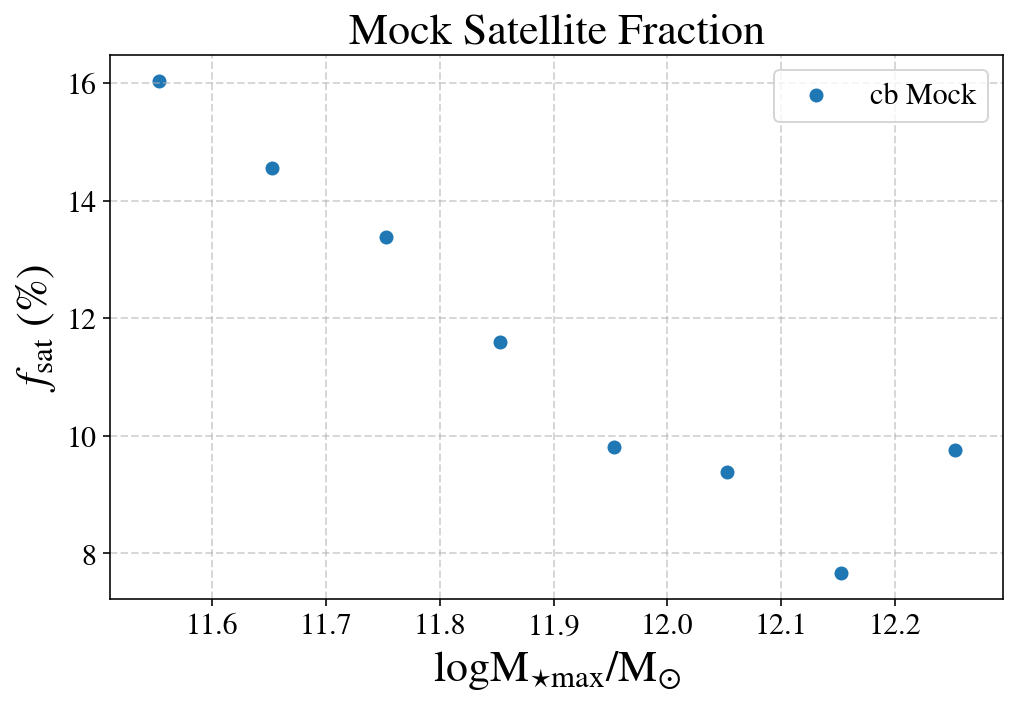

In [17]:
fig = plt.figure(figsize = [8,5])
ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)


for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

ax1.scatter(mass_center_cb, f_sat_cb, label = "cb Mock")
    
    
ax1.set_xlabel(r'$\log \rm M_{\star \rm max} / M_{\odot}$', fontsize = 22)
ax1.set_ylabel(r'$f_{\rm sat}$ (%)', fontsize = 22)
ax1.set_title('Mock Satellite Fraction', fontsize = 22)
ax1.legend(fontsize = 15)
plt.savefig('um_fsat.png', dpi = 1000)

These satellite fraction values are VERY different from our previous analyses. Let's plot them simultaneously.

In [18]:
# load the arrays from our previous analysis
um = np.load('um.npy')
hsc = np.load('hsc.npy')

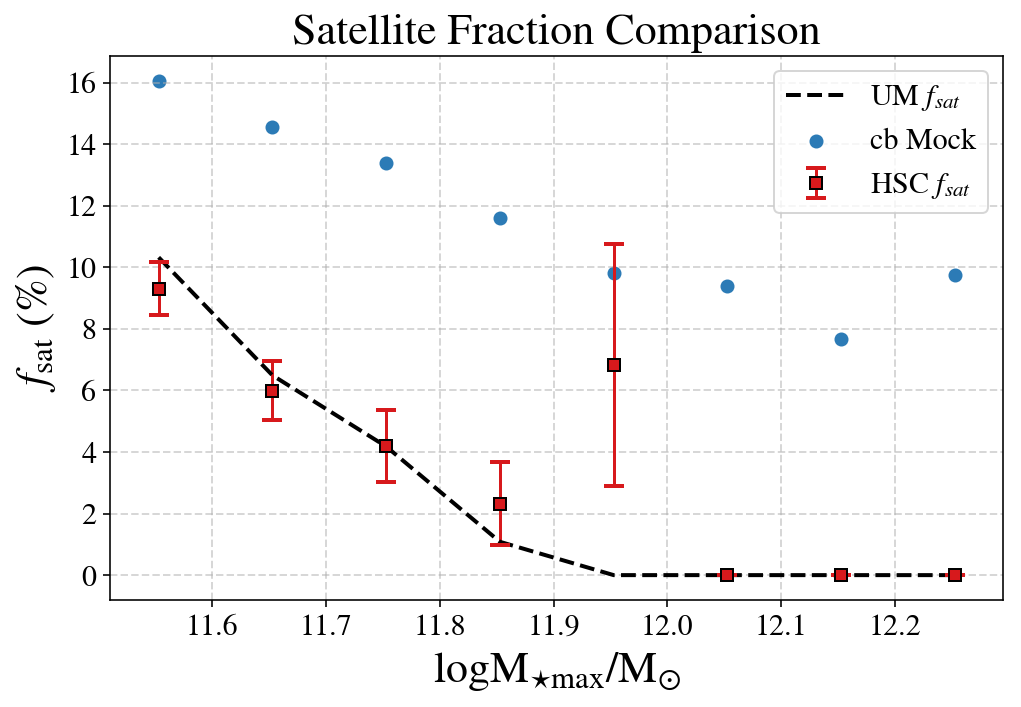

In [26]:
# now plot them on the same plot
fig = plt.figure(figsize = [8,5])
ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)


for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

ax1.scatter(mass_center_cb, f_sat_cb, color = '#2c7bb6', label = "cb Mock")
ax1.plot(um[0], um[1], color = 'k', linewidth = 2,ls = '--', label = 'UM $f_{sat}$')
ax1.errorbar(hsc[0], hsc[1], hsc[2], color = '#d7191c',fmt='s',mec = 'k',capthick=2, capsize=5, label = 'HSC $f_{sat}$')
    
    
ax1.set_xlabel(r'$\log \rm M_{\star \rm max} / M_{\odot}$', fontsize = 22)
ax1.set_ylabel(r'$f_{\rm sat}$ (%)', fontsize = 22)
ax1.set_title('Satellite Fraction Comparison', fontsize = 22)
ax1.legend(fontsize = 15)
plt.savefig('um_fsat.png', dpi = 1000)